# Baseline Model - Linear Models

In [ ]:
# libraries
import pandas as pd
import numpy as np
from pyproj import Geod
import json

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# connect to data source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import data
df_path = '/content/drive/MyDrive/CapstoneProject/ryanair_clean_datasets/train_extended.csv'
df = pd.read_csv(df_path)

In [ ]:
# Remove data registered after arrival
df = df.drop(['ActualRoute','DepartureActual', 'ArrivalActual', 'BlockTime', 'TaxiOut', 'FlightTime'], axis=1)

# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled'], axis=1)

# Remove negative burnoff
df = df[df["Burnoff"] > 0]

In [ ]:
df.columns

Index(['AircraftCapacity', 'AircraftTypeGroup', 'BlockTimeScheduled',
       'Burnoff', 'Adults', 'Children', 'Freight', 'Infants', 'Bags',
       'PlannedZeroFuelWeight', 'PlannedTOW', 'PlannedTripTime',
       'TeledyneRampWeight'],
      dtype='object')

In [ ]:
# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
# Define the preprocessor
categorical_columns = ["AircraftTypeGroup"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OrdinalEncoder(), categorical_columns),
        ("numerical", StandardScaler(), numerical_columns),
    ]
)

In [ ]:
def best_model(X_train, Y_train):
    seed = 21
    folds = 10
    metric = 'neg_mean_squared_error'

    models = {
        "LinearRegression": LinearRegression(),
        "ElasticNet": ElasticNet(),
        "BayesianRidge": BayesianRidge(),
    }

    model_results = []
    model_names = []

    for model_name in models:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[model_name])])
        k_fold = KFold(n_splits=folds, random_state=seed, shuffle=True)
        results = cross_val_score(pipeline, X_train, Y_train, cv=k_fold, scoring=metric)
        rmse_results = np.sqrt(-results)

        model_results.append(rmse_results)
        model_names.append(model_name)

        print(f"{model_name:>20}: {rmse_results.mean():.2f} ({rmse_results.std():.2f})")

    figure = plt.figure()
    figure.suptitle('Regression Models Comparison with Preprocessing')
    ax = figure.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylabel("RMSE")
    plt.margins(0.05, 0.1)
    plt.show()

    LinearRegression: 277.90 (3.05)
          ElasticNet: 470.32 (2.26)
       BayesianRidge: 277.90 (3.05)


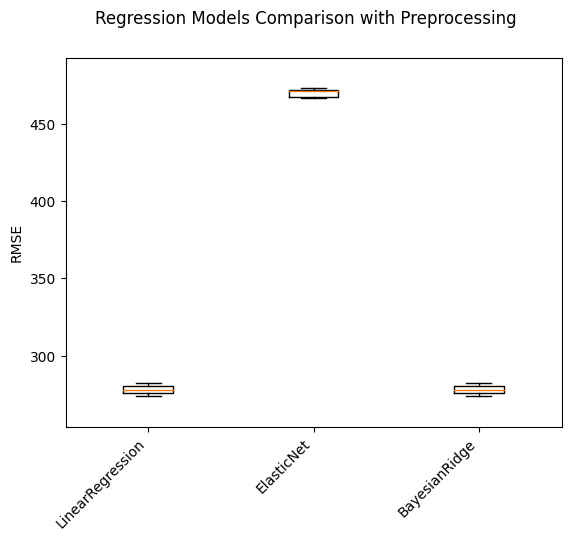

In [ ]:
best_model(X_train, y_train)

## Best Performer: BayesianRidge

In [ ]:
br_regressor = BayesianRidge()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('br_regressor', br_regressor)])

pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {r2:.2f}")

Test RMSE: 277.02
Test MAE: 203.46
Test R^2: 0.98


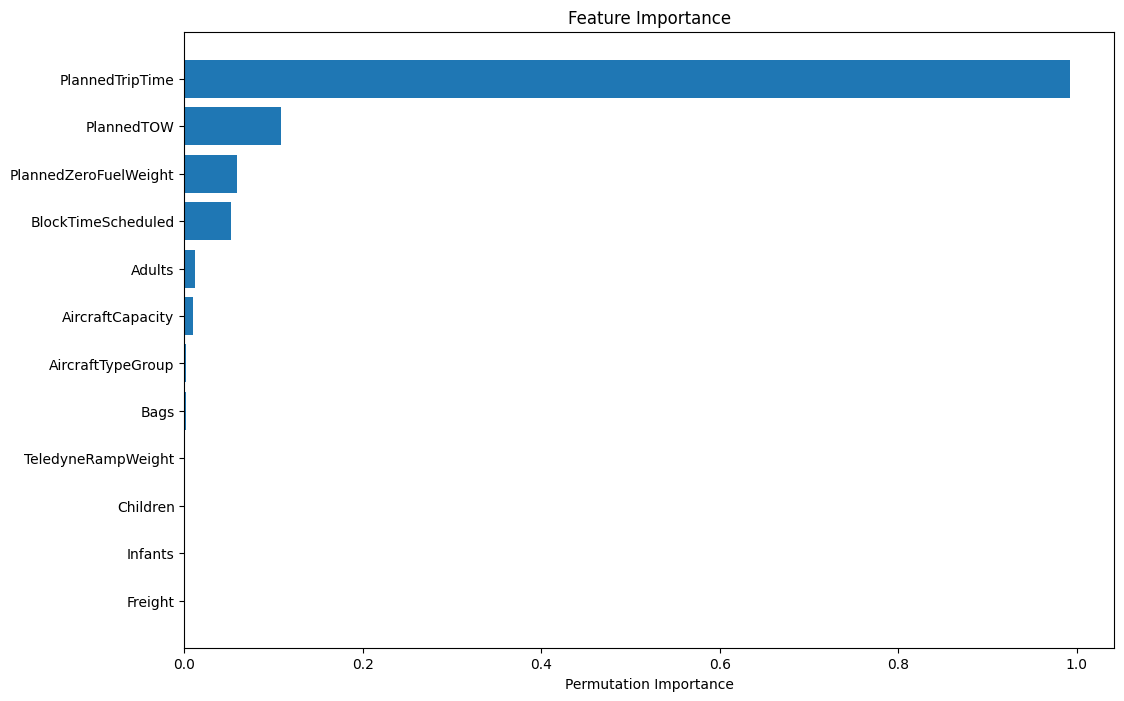

In [ ]:
perm_importance = permutation_importance(pipeline, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

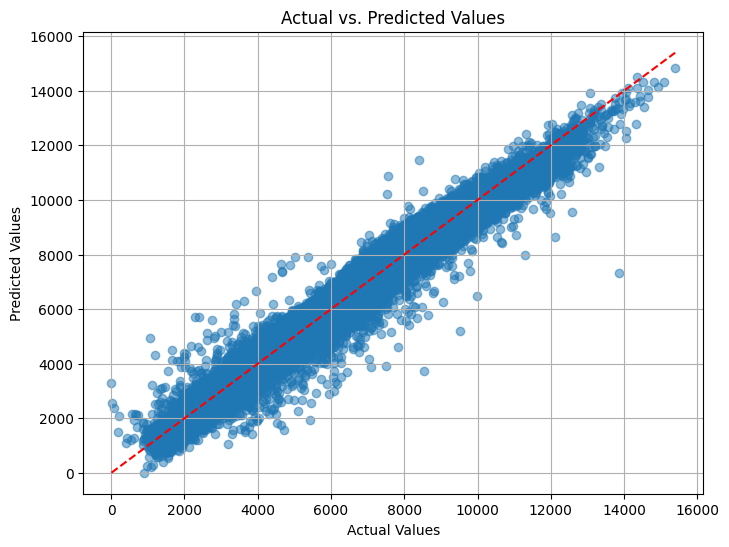

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plotting actual vs. predicted values
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the identity line for reference
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.grid(True)
plt.show()

# Baseline Model with Feature Engineering

In [ ]:
# import preprocessed data
df_path = '/content/drive/MyDrive/CapstoneProject/ryanair_clean_datasets/df_fe.csv'
df = pd.read_csv(df_path)

In [ ]:
# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled'], axis=1) # Data obtaines after arrival removed in preprocessing

In [ ]:
df.columns

Index(['AircraftCapacity', 'AircraftTypeGroup', 'BlockTimeScheduled',
       'Burnoff', 'Adults', 'Children', 'Freight', 'Infants', 'Bags',
       'PlannedZeroFuelWeight', 'PlannedTOW', 'PlannedTripTime',
       'TeledyneRampWeight', 'FuelWeight', 'Distance', 'AircraftAge'],
      dtype='object')

In [ ]:
# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
# Define the preprocessor
categorical_columns = ["AircraftTypeGroup"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OrdinalEncoder(), categorical_columns),
        ("numerical", StandardScaler(), numerical_columns),
    ]
)

In [ ]:
def best_model(X_train, Y_train):
    seed = 21
    folds = 10
    metric = 'neg_mean_squared_error'

    models = {
        "LinearRegression": LinearRegression(),
        "ElasticNet": ElasticNet(),
        "BayesianRidge": BayesianRidge(),
    }

    model_results = []
    model_names = []

    for model_name in models:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[model_name])])
        k_fold = KFold(n_splits=folds, random_state=seed, shuffle=True)
        results = cross_val_score(pipeline, X_train, Y_train, cv=k_fold, scoring=metric)
        rmse_results = np.sqrt(-results)

        model_results.append(rmse_results)
        model_names.append(model_name)

        print(f"{model_name:>20}: {rmse_results.mean():.2f} ({rmse_results.std():.2f})")

    figure = plt.figure()
    figure.suptitle('Regression Models Comparison with Preprocessing')
    ax = figure.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylabel("RMSE")
    plt.margins(0.05, 0.1)
    plt.show()

    LinearRegression: 267.43 (1.99)
          ElasticNet: 396.10 (2.11)
       BayesianRidge: 267.43 (1.98)


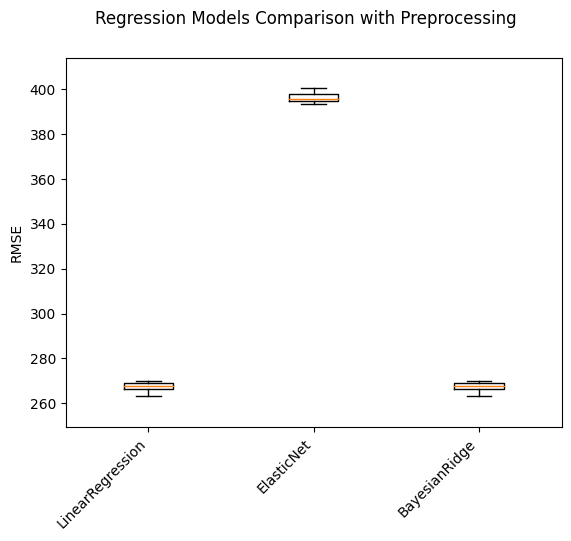

In [ ]:
best_model(X_train, y_train)

## Best Performer: BayesianRidge

In [ ]:
br_regressor = BayesianRidge()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('br_regressor', br_regressor)])

pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {r2:.2f}")

Test RMSE: 269.47
Test MAE: 195.07
Test R^2: 0.98


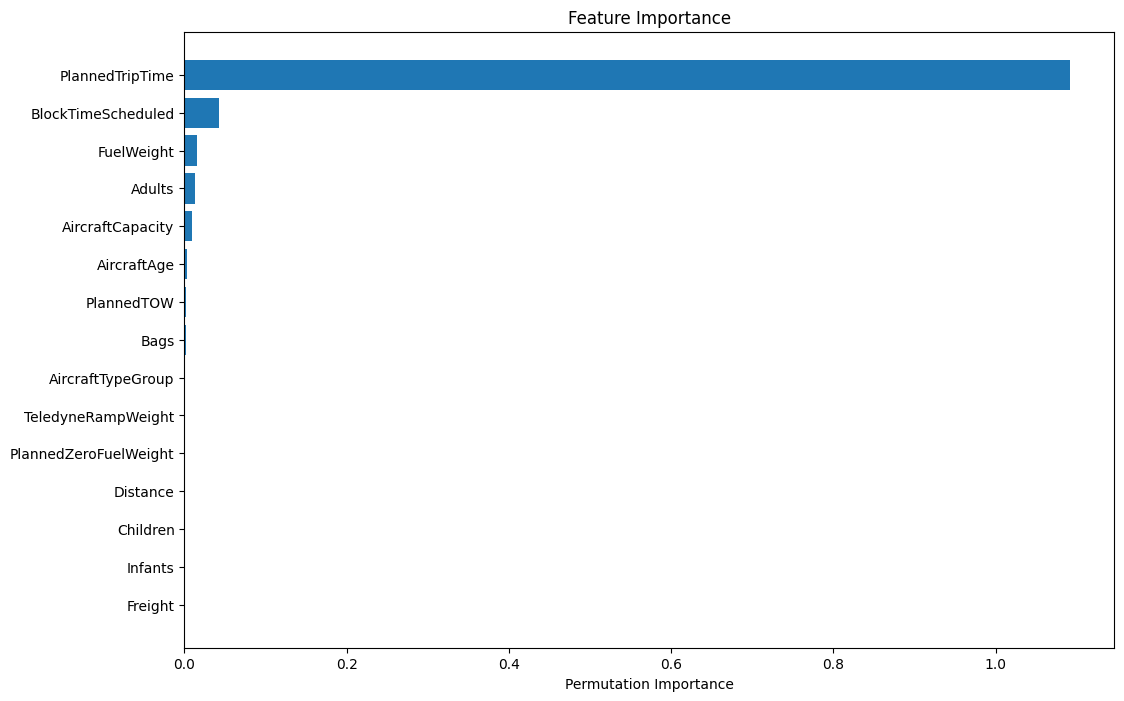

In [ ]:
perm_importance = permutation_importance(pipeline, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

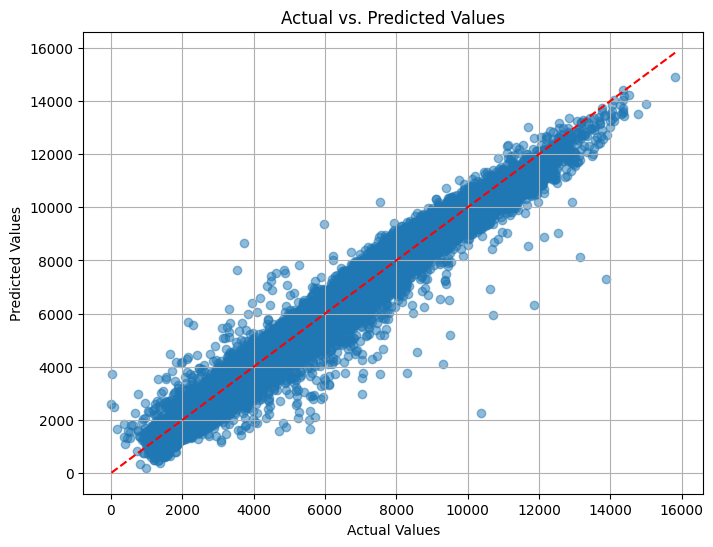

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plotting actual vs. predicted values
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the identity line for reference
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.grid(True)
plt.show()